# Calculating ground states on large scale systems: Quantum Krylov Subspaces

### Imports and definitions



In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from typing import Union, List
import warnings
warnings.filterwarnings('ignore')

from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit.providers.fake_provider import Fake20QV1
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

import itertools as it

def solve_regularized_gen_eig(h: np.ndarray, s:np.ndarray, threshold: float, k: int =1, return_dimn: bool = False) -> Union[float, List[float]]:
    """
    Method for solving the generalized eigenvalue problem with regularization

    Args:
        h (numpy.ndarray):
            The effective representation of the matrix in the Krylov subspace
        s (numpy.ndarray):
            The matrix of overlaps between vectors of the Krylov subspace
        threshold (float):
            Cut-off value for the eigenvalue of s
        k (int):
            Number of eigenvalues to return
        return_dimn (bool):
            Whether to return the size of the regularized subspace

    Returns:
        lowest k-eigenvalue(s) that are the solution of the regularized generalized eigenvalue problem

    
    """
    s_vals, s_vecs = sp.linalg.eigh(s)
    s_vecs = s_vecs.T
    good_vecs = np.array([vec for val, vec in zip(s_vals, s_vecs) if val > threshold])
    h_reg = good_vecs.conj() @ h @ good_vecs.T
    s_reg = good_vecs.conj() @ s @ good_vecs.T
    if k==1:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][0], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][0]
    else:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k]
        


def single_particle_gs(H_op, n_qubits):
    H_x = []
    for p, coeff in H_op.to_list():
        H_x.append(set([i for i,v in enumerate(Pauli(p).x) if v]))

    H_z = []
    for p, coeff in H_op.to_list():
        H_z.append(set([i for i,v in enumerate(Pauli(p).z) if v]))

    H_c = H_op.coeffs

    print('n_sys_qubits', n_qubits)

    # n_exc particle Hamiltonian:

    n_exc = 1
    sub_dimn = int(sp.special.comb(n_qubits+1,n_exc))
    print('n_exc', n_exc, ', subspace dimension', sub_dimn)

    few_particle_H = np.zeros((sub_dimn,sub_dimn), dtype=complex)

    sparse_vecs = [set(vec) for vec in it.combinations(range(n_qubits+1),r=n_exc)] # list all of the possible sets of n_exc indices of 1s in n_exc-particle states

    m = 0
    for i, i_set in enumerate(sparse_vecs):
        for j, j_set in enumerate(sparse_vecs):
            m += 1
            # if m % int((sub_dimn**2)/100) == 0:
            #     print(np.round(m/int((sub_dimn**2)/100),2), '% complete, time =', time.time()-start_time)
            #     start_time = time.time()

            if len(i_set.symmetric_difference(j_set)) <= 2:

                for p_x, p_z, coeff in zip(H_x, H_z, H_c):

                    if i_set.symmetric_difference(j_set) == p_x:
                        sgn = ((-1j)**len(p_x.intersection(p_z)))*((-1)**len(i_set.intersection(p_z)))
                    else:
                        sgn = 0

                    few_particle_H[i,j] += sgn*coeff

    gs_en = min(np.linalg.eigvalsh(few_particle_H))
    print('single particle ground state energy: ', gs_en)
    return gs_en




### Define Hamiltonian

Let's consider the Heisenberg Hamiltonian for $N$ qubits on a linear chain: $H= J \sum_{i,j}^N X_i X_j + Y_i Y_j - Z_i Z_j$

In [2]:
# Define problem Hamiltonian.
n_qubits = 6
J = 1 # coupling strength for ZZ interaction

# Define the Hamiltonian: 
H_int = [['I']*n_qubits for _ in range(3*(n_qubits-1))]
for i in range(n_qubits-1):
    H_int[i][i] = 'Z'
    H_int[i][i+1] = 'Z'
for i in range(n_qubits-1):
    H_int[n_qubits-1+i][i] = 'X'
    H_int[n_qubits-1+i][i+1] = 'X'
for i in range(n_qubits-1):
    H_int[2*(n_qubits-1)+i][i] = 'Y'
    H_int[2*(n_qubits-1)+i][i+1] = 'Y'
H_int = [''.join(term) for term in H_int]
H_tot = [(term, -J) if term.count('Z') == 2 else (term, 1) for term in H_int]

# Get operator
H_op = SparsePauliOp.from_list(H_tot)
print(H_tot)

[('ZZIIII', -1), ('IZZIII', -1), ('IIZZII', -1), ('IIIZZI', -1), ('IIIIZZ', -1), ('XXIIII', 1), ('IXXIII', 1), ('IIXXII', 1), ('IIIXXI', 1), ('IIIIXX', 1), ('YYIIII', 1), ('IYYIII', 1), ('IIYYII', 1), ('IIIYYI', 1), ('IIIIYY', 1)]


Heuristically choose `dt` (based on upper bounds)

In [3]:
from qiskit.quantum_info import Pauli
# Get Hamiltonian restricted to single-particle states
single_particle_H = np.zeros((n_qubits,n_qubits))
for i in range(n_qubits):
    for j in range(i+1):
        for p, coeff in H_op.to_list():
            p_x = Pauli(p).x
            p_z = Pauli(p).z
            if all(p_x[k] == ((i==k)+(j==k))%2 for k in range(n_qubits)):
                sgn = ((-1j)**sum(p_z[k] and p_x[k] for k in range(n_qubits)))*((-1)**p_z[i])
            else:
                sgn = 0
            single_particle_H[i,j] += sgn*coeff
for i in range(n_qubits):
    for j in range(i+1,n_qubits):
        single_particle_H[i,j] = np.conj(single_particle_H[j,i])

# Set dt according to spectral norm
dt = np.pi/np.linalg.norm(single_particle_H, ord=2)
dt

0.6283185307179587

### Set parameters for the algorithm

In [4]:
# Set parameters for quantum Krylov algorithm
krylov_dim = 20 # size of krylov subspace
num_trotter_steps = 8
dt_circ = dt/num_trotter_steps

### Decompose time-evolution operator with Suzuki-Trotter decomposition
Instead of implementing the time-evolution operator exactly we can use the Suzuki-Trotter decomposition to implement an approximation of it. Repeating several times a certain order Trotter decomposition gives us further reduction of the error introduced from the approximation. In the following, we directly build the Trotter implementation in the most efficient way for the interaction graph of the Hamiltonian we are considering (nearest neighbor interactions only). In practice we insert Pauli rotations $R_{xx}$, $R_{yy}$, $R_{zz}$ with a parametrized angle $t$ which correspond to the approximate implementation of $e^{-i (XX + YY + ZZ) t}$. This gives a much shallower circuit than what is obtained using the generic `PauliEvolutionGate()` functionality. 

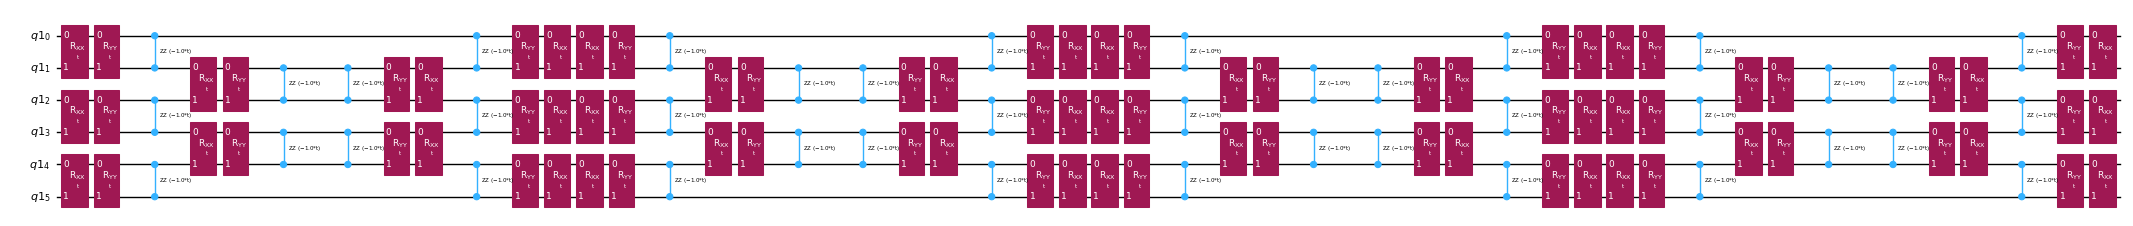

In [5]:
t = Parameter('t')

# Create instruction for rotation about XX+YY-ZZ:
Rxyz_circ = QuantumCircuit(2)
Rxyz_circ.rxx(t,0,1)
Rxyz_circ.ryy(t,0,1)
Rxyz_circ.rzz(-t,0,1)
Rxyz_instr = Rxyz_circ.to_instruction(label='RXX+YY-ZZ')

interaction_list = [[[i, i+1] for i in range(0, n_qubits-1, 2)], [[i, i+1] for i in range(1, n_qubits-1, 2)]] # linear chain

qr = QuantumRegister(n_qubits)
trotter_step_circ = QuantumCircuit(qr)
for i, color in enumerate(interaction_list):
    for interaction in color:
        trotter_step_circ.append(Rxyz_instr, interaction)
reverse_trotter_step_circ = trotter_step_circ.reverse_ops()

qc_evol = QuantumCircuit(qr)
for step in range(num_trotter_steps):
    if step % 2 == 0:
        qc_evol = qc_evol.compose(trotter_step_circ)
    else:
        qc_evol = qc_evol.compose(reverse_trotter_step_circ)

qc_evol.decompose().draw('mpl', fold=-1, scale = 0.5)



### Use an optimized circuit for state preparation

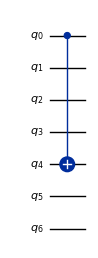

In [6]:
controlled_state_prep = QuantumCircuit(n_qubits + 1)
controlled_state_prep.cx(0,int(n_qubits/2)+1)
controlled_state_prep.draw('mpl', fold=-1, scale=0.5)


controlled_state_prep.draw('mpl', fold=-1, scale=0.5)

### Template circuits for calculating matrix elements of $\tilde{S}$ and $\tilde{H}$ via Hadamard test
The only difference between the circuits used in the Hadamard test will be the phase in the time-evolution operator and the observables measured. Therefore we can prepare a template circuit which represent the generic circuit for the Hadamard test, with placeholders for the gates that depend on the time-evolution operator.

In [7]:
# Parameters for the template circuits
parameters = []
for idx_ket in range(1, krylov_dim):
    parameters.append(dt_circ*(idx_ket))

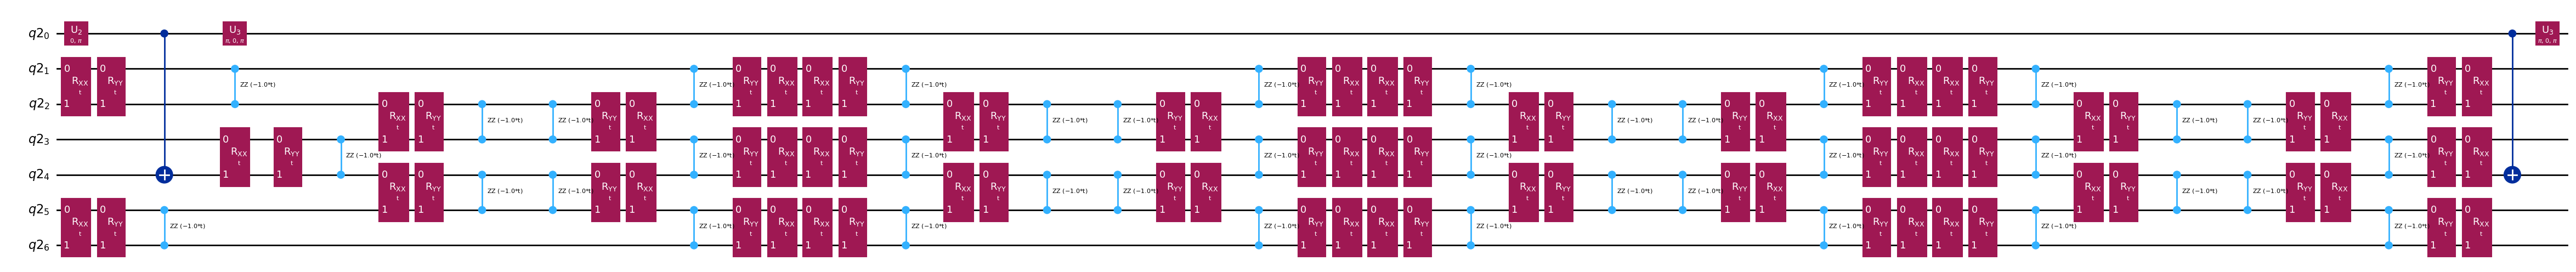

In [8]:
# Create hadamard test circuit
qr = QuantumRegister(n_qubits+1)
qc = QuantumCircuit(qr)
qc.h(0)
qc.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
# qc_real.barrier()
qc.compose(qc_evol, list(range(1, n_qubits+1)), inplace=True)
# qc_real.barrier()
qc.x(0)
qc.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc.x(0)

qc.decompose().draw('mpl', fold=-1)

## TODO: we don't need real and imaginary part circuits
Just have 2 sets of observables for measuring X (real) and Y (imaginary). This saves runtime in the case of PEA where the noise model is learnt each time. In this case we can submit all circuits for either S and H together (instead of splitting real and imaginary)

## Step 3: Execute using a quantum primitive

Instantiate the backend and set runtime parameters

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Batch
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeGuadalupeV2
from qiskit_aer import AerSimulator


SIM = True
NOISE = False
# service = QiskitRuntimeService(instance='ibm-q-internal/technical-enable/utokyol3enableme')#
service = QiskitRuntimeService(instance='quantum-demonstrations/main/krylov-gs')
# service = QiskitRuntimeService(instance='ibm-q-internal/performance/reservations')
# service = QiskitRuntimeService(name="staging", instance='ibm-q-internal/internal-test/fast-flux')
# service = QiskitRuntimeService(instance='ibm-q-internal/performance/reservations')

# # IBMQ.load_account()
# provider = IBMProvider(name="staging")
# backend = provider.get_backend('ibm_montecarlo')
# cmap_gen = GateDirection(backend=backend).coupling_map
# coupling_map = list(cmap_gen.get_edges())
# coupling_map = [tuple(pair) for pair in coupling_map]


if SIM:
    # backend = service.least_busy(simulator=True)
    
    if NOISE:
        backend = AerSimulator.from_backend(FakeGuadalupeV2(), seed_simulator=42)

    else:
        backend = AerSimulator()

else:
    # backend_id = 'ibm_pinguino1'
    # backend_id = 'ibm_torino'
    # backend_id = 'ibm_montecarlo'
    backend_id = 'ibm_kyiv'
    backend = service.backend(backend_id)

shots = 300000


### Transpile + schedule with DD

In [10]:
from qiskit.circuit.library import XGate, YGate, RZGate
from qiskit.transpiler import InstructionProperties
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

if not SIM:


    target = backend.target
    basis_gates = list(target.operation_names)


    X = XGate()
    Y = YGate()
    
    # dd_sequence = [X, X, X, X]

    dd_sequence=[XGate(), RZGate(np.pi), XGate(), RZGate(-np.pi)]
    spacing = [1 / 4, 1 / 2, 0, 0, 1 / 4]


    
    y_gate_properties = {}
    for qubit in range(target.num_qubits):
        y_gate_properties.update(
            {
                (qubit,): InstructionProperties(
                    duration=target["x"][(qubit,)].duration,
                    error=target["x"][(qubit,)].error,
                )
            }
        )
    if 'y' not in target.operation_names:
        target.add_instruction(YGate(), y_gate_properties)

    pm = generate_preset_pass_manager(optimization_level=3, backend=backend, basis_gates=basis_gates)


    pm.scheduling = PassManager(
        [
            ALAPScheduleAnalysis(target=target),
            PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence, spacing=spacing),
        ]
    )

    qc_trans = pm.run(qc)

elif SIM and NOISE:
    target = backend.target
    basis_gates = list(target.operation_names)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend, basis_gates=basis_gates)

    qc_trans = pm.run(qc)

In [11]:
qc_trans.draw('mpl', fold=-1, idle_wires=False, scale=0.5)


NameError: name 'qc_trans' is not defined

In [ ]:
qc_trans.depth(lambda x: x[0].num_qubits==2)


68

In [161]:
qc_trans.count_ops()

OrderedDict([('rz', 886),
             ('sx', 449),
             ('delay', 305),
             ('ecr', 168),
             ('x', 67)])

In [ ]:
# from qiskit.visualization import timeline_drawer
# from qiskit.transpiler.passes.scheduling import ALAPSchedule
# from qiskit.transpiler import PassManager, InstructionDurations

# b_circ = S_real_circ_trans_dd.assign_parameters({t:1})
# durations = InstructionDurations().from_backend(backend)
# pm = PassManager([ALAPSchedule(durations=durations)])
# sched_circ = pm.run(b_circ)

# timeline_drawer(sched_circ, show_idle=False)
# # timeline_drawer(b_circ)

### Create PUBs for execution with Estimator

In [12]:
# Define observables to measure for S
observable_S_real = 'I'*(n_qubits) + 'X'
observable_S_imag = 'I'*(n_qubits) + 'Y'

if not SIM or (SIM and NOISE):

    layout = qc_trans.layout # get layout of transpiled circuit

    observable_op_real = SparsePauliOp(observable_S_real) # define a sparse pauli operator for the observable
    observable_op_imag = SparsePauliOp(observable_S_imag)
    observable_op_real = observable_op_real.apply_layout(layout) # apply physical layout to the observable
    observable_op_imag = observable_op_imag.apply_layout(layout)
    observable_S_real = observable_op_real.paulis.to_labels() # get the label of the physical observable
    observable_S_imag = observable_op_imag.paulis.to_labels() 


# Define a set of observables to measure
# else:
    # observable = [observable_S_real, observable_S_imag]

observables_S = [[observable_S_real], [observable_S_imag]]

# Define a sweep over parameter values
params = np.vstack(parameters).T


# Define observables to measure for H
# Hamiltonian terms to measure
observable_list = []
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
    # print(pauli)
    observable_H_real = pauli[::-1].to_label() + 'X'
    observable_H_imag = pauli[::-1].to_label() + 'Y'
    observable_list.append([observable_H_real])
    observable_list.append([observable_H_imag])


if not SIM or (SIM and NOISE):

    layout = qc_trans.layout

    observable_trans_list = []
    for observable in observable_list:
        observable_op = SparsePauliOp(observable)
        observable_op = observable_op.apply_layout(layout)
        observable_trans_list.append([observable_op.paulis.to_labels()])

    observable_list = observable_trans_list


observables_H = observable_list



# Estimate the expectation value for all combinations of
# observables and parameter values, where the pub result will have
# shape (# observables, # parameter values).
if not SIM or (SIM and NOISE):
    pub = (qc_trans, observables_S + observables_H, params)

else:
    pub = (qc.decompose(), observables_S + observables_H, params)



In [15]:
parameters

[0.07853981633974484,
 0.15707963267948968,
 0.23561944901923454,
 0.31415926535897937,
 0.3926990816987242,
 0.4712388980384691,
 0.5497787143782139,
 0.6283185307179587,
 0.7068583470577036,
 0.7853981633974484,
 0.8639379797371932,
 0.9424777960769382,
 1.021017612416683,
 1.0995574287564278,
 1.1780972450961726,
 1.2566370614359175,
 1.3351768777756623,
 1.4137166941154071,
 1.492256510455152]

In [14]:
observables_S

[['IIIIIIX'], ['IIIIIIY']]

In [13]:
observables_H

[['IIIIZZX'],
 ['IIIIZZY'],
 ['IIIZZIX'],
 ['IIIZZIY'],
 ['IIZZIIX'],
 ['IIZZIIY'],
 ['IZZIIIX'],
 ['IZZIIIY'],
 ['ZZIIIIX'],
 ['ZZIIIIY'],
 ['IIIIXXX'],
 ['IIIIXXY'],
 ['IIIXXIX'],
 ['IIIXXIY'],
 ['IIXXIIX'],
 ['IIXXIIY'],
 ['IXXIIIX'],
 ['IXXIIIY'],
 ['XXIIIIX'],
 ['XXIIIIY'],
 ['IIIIYYX'],
 ['IIIIYYY'],
 ['IIIYYIX'],
 ['IIIYYIY'],
 ['IIYYIIX'],
 ['IIYYIIY'],
 ['IYYIIIX'],
 ['IYYIIIY'],
 ['YYIIIIX'],
 ['YYIIIIY']]

## Run circuits

Circuits for $t=0$ are classically calculable

In [79]:
from qiskit.quantum_info import StabilizerState, Pauli



qc_cliff = qc.assign_parameters({t:0})

# observables_H_real_cliff = []
# observables_H_imag_cliff = []
# for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
#     # print(pauli)
#     observable_real = pauli[::-1].to_label() + 'X'
#     observable_imag = pauli[::-1].to_label() + 'Y'
#     observables_H_real_cliff.append(observable_real)
#     observables_H_imag_cliff.append(observable_imag)



# Get expectation values from experiment
S_expval_real = StabilizerState(qc_cliff).expectation_value(Pauli('I'*(n_qubits) + 'X'))
S_expval_imag = StabilizerState(qc_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Y'))

# Get expectation values
S_expval = S_expval_real + 1j*S_expval_imag

H_expval = 0
for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    # Get expectation values from experiment
    expval_real = StabilizerState(qc_cliff).expectation_value(Pauli(pauli[::-1].to_label() + 'X'))
    expval_imag = StabilizerState(qc_cliff).expectation_value(Pauli(pauli[::-1].to_label() + 'Y'))
    expval = expval_real + 1j*expval_imag


    # Fill-in matrix elements
    H_expval += coeff*expval


H_expval

(-1+0j)

Execute circuits for $\tilde{S}$ and $\tilde{H}$ with the Estimator

In [156]:
# from pec_runtime.primitives import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
if SIM:
    with Session(backend=backend) as session:
        estimator = Estimator(session=session)
        job = estimator.run([pub], precision=1/np.sqrt(shots))
else:

    # Experiment options
    num_randomizations = 200
    num_randomizations_learning = 20
    max_batch_circuits = 20
    shots_per_randomization = 100
    learning_pair_depths = [0, 4, 24]
    noise_factors = [1, 1.3, 1.6]

    # Base option formatting
    options = {
        # Builtin resilience settings for ZNE
        "resilience": {
            "measure_mitigation": True,
            "zne_mitigation": True,
            "zne": {"noise_factors": noise_factors},

            # TREX noise learning configuration
            "measure_noise_learning": {
                "num_randomizations": num_randomizations_learning,
                "shots_per_randomization": shots_per_randomization,
            },
            
            # PEA noise model configuration
            "layer_noise_learning": {
                "max_layers_to_learn": 10,
                "layer_pair_depths": learning_pair_depths,
                "shots_per_randomization": shots_per_randomization,
                "num_randomizations": num_randomizations_learning,
            },
        },
        
        # Randomization configuration
        "twirling": {
            "num_randomizations": num_randomizations,
            "shots_per_randomization": shots_per_randomization,
            "strategy": "all",
        },

        # Experimental settings for PEA method
        "experimental": {
            # # Just in case, disable any further qiskit transpilation not related to twirling / DD
            # "skip_transpilation": True,

            # Execution configuration
            "execution": {
                "max_pubs_per_batch_job": max_batch_circuits,
                "fast_parametric_update": True,
            },

            # Error Mitigation configuration
            "resilience": {
                # ZNE Configuration
                "zne": {
                    "amplifier": "pea",
                    "return_all_extrapolated": True,
                    "return_unextrapolated": True,
                    "extrapolated_noise_factors": [0, 0.25, 0.5, 0.75] + noise_factors,
                }
            }
        }
    }

    with Batch(backend=backend) as batch:
        # Estimator
        estimator = Estimator(session=batch, options=options)

        # # estimator.options.default_shots = 3000

        # # twirling
        # estimator.options.twirling.shots_per_randomization = 100
        # estimator.options.twirling.num_randomizations = 500
        # estimator.options.twirling.strategy = 'all'

        # # DD
        # estimator.options.dynamical_decoupling.enable = True
        # estimator.options.dynamical_decoupling.sequence_type = 'XY4'


        # Additional options to enable and modify PEA based ZNE
        # estimator.options.resilience.zne.amplifier = "pea"
        estimator.options.resilience.zne.noise_factors = noise_factors

        # #trex
        # estimator.options.resilience.measure_noise_learning.num_randomizations = 100
        # estimator.options.resilience.measure_noise_learning.shots_per_randomization = 100

        # #pea learning
        # estimator.options.resilience.layer_noise_learning.layer_pair_depths = [0, 4, 24]
        # estimator.options.resilience.layer_noise_learning.shots_per_randomization = 100
        # estimator.options.resilience.layer_noise_learning.num_randomizations = 15

        # # experimental options
        # estimator.options.experimental.execution.fast_parametric_update = True
        # estimator.options.experimental.resilience.zne.amplifier = 'pea'
        # estimator.options.experimental.resilience.zne.return_all_extrapolated = True
        # estimator.options.experimental.resilience.zne.return_unextrapolated = True
        # estimator.options.experimental.resilience.zne.extrapolated_noise_factors = [1, 1.3, 1.6]


        job = estimator.run([pub], precision=1)


In [162]:
job_id = job.job_id()

print(job_id)


cst4s44ah4b0008cxc5g


## Step 4: Post-process and analyze results

#### Plot extrapolated values

In [82]:
# qubit = 0
# metadata = job_S_real.result().metadata
# pub_result = job_S_real.result()[0]
# data = pub_result.data

# evs_auto = data.evs[qubit]
# stds_auto = data.stds[qubit]
# evs_extrap = data.evs_extrapolated[qubit]
# stds_extrap = data.stds_extrapolated[qubit]
# evs_raw = data.evs_noise_factors[qubit]
# stds_raw = data.stds_noise_factors[qubit]


# num_params = evs_auto.shape[0]
# angles = np.asarray(parameters).ravel()
# if angles.shape != (num_params,):
#     raise ValueError(
#         f"Incorrect number of angles for input data {angles.size} != {num_params}"
#     )

# # Make a square subplot
# num_cols = int(np.ceil(np.sqrt(num_params)))
# num_rows = int(np.ceil(num_params / num_cols))
# fig, axes = plt.subplots(
#     num_rows, num_cols, sharex=True, sharey=True, figsize=(12, 5)
# )
# fig.suptitle(f"ZNE data for virtual qubit {qubit}")

# for pidx, ax in zip(range(num_params), axes.flat):
    
#     # Plot auto extrapolated
#     ax.errorbar(
#         0, evs_auto[pidx], stds_auto[pidx], fmt="o", label="PEA (automatic)"
#     )
    
#     extrapolated_noise_factors = metadata['resilience']['zne']['extrapolated_noise_factors']
#     pub_metadata = pub_result.metadata

#     # # Plot extrapolators
#     # extrapolator = np.asarray(metadata["resilience"]["zne"]['extrapolator'], dtype=object)[0]
#     # for i, method in enumerate(extrapolator):
#     #     ax.errorbar(
#     #         extrapolated_noise_factors, evs_extrap[pidx, i], stds_extrap[pidx, i], fmt="-", alpha=0.5, label=f"PEA ({method})"
#     #     )

#     # Plot raw
#     ax.errorbar(
#         metadata['resilience']['zne']['noise_factors'], evs_raw[pidx], stds_raw[pidx], fmt="d", label="Raw"
#     )

#     ax.set_yticks([0, 0.5, 1, 1.5, 2])
#     ax.set_ylim(-max(1, 1.1*max(evs_auto)), max(1, 1.1*max(evs_auto)))
    
#     # ax.set_xticks([0, *noise_factors])
#     ax.set_title(f"θ/π = {angles[pidx]/np.pi:.2f}")
#     if pidx == 0:
#         ax.set_ylabel(r"$\langle Z_{" + str(qubit) + r"} \rangle$")
#     if pidx == num_params - 1:
#         ax.set_xlabel("Noise Factor")
#         ax.legend()


### Calculate projected $\tilde{H}$ and $S$ matrices
First calculate the phase accumulated by the |0> state during the uncontrolled time evolution

In [163]:
prefactors = []
E0t_array = []
for i, circ in enumerate(iter(qc_evol.assign_parameters([(i*dt)/num_trotter_steps]) for i in range(1, krylov_dim))):
    phase = 1.0
    E0t = 0
    for instruction in circ.data:
        if instruction.operation.name != 'swap' and instruction.operation.name != 'barrier':
            # All the non-swap gates are XX+YY+ZZ rotations, which add a phase to the all-zeros state.
            if instruction.operation.params:
                E0t += float(instruction.operation.params[0])
                # phase *= np.exp(1j*float(instruction.operation.params[0])/2)
                phase *= np.exp(-1j*float(instruction.operation.params[0])/2) # NY added, we need to `subtract` the E0 * t so minus sign
            # assert(float(instruction.operation.params[0]._symbol_expr) == i*dt/n_T_step)
    prefactors.append(phase)

Once we have the results of the circuit executions we can post-process the data to calculate the matrix elements of $\tilde{S}$

In [164]:
results = job.result()[0]

RuntimeJobFailureError: 'Unable to retrieve job result. Job estimator_cpq86pkkpfgg57kl2vb0_902d_5 cancelled due to compilation timeout 8100000000000.'

In [85]:
import itertools
# Assemble S, the overlap matrix of dimension D:
S_first_row = np.zeros(krylov_dim, dtype=complex)
S_first_row[0] = 1+0j

# Add in ancilla-only measurements:
for i in range(krylov_dim-1):

    # Get expectation values from experiment
    expval_real = results.data.evs[0, i] # automatic extrapolated evs if ZNE is used
    expval_imag = results.data.evs[1, i] # automatic extrapolated evs if ZNE is used

    # Get expectation values
    expval = expval_real + 1j*expval_imag
    # Get the coefficients and expectation values corresponding to actual terms in the Hamiltonian (as opposed to the ancilla-only measurements).
    S_first_row[i+1] += prefactors[i]*expval

S_first_row_list =  S_first_row.tolist() #for saving purposes     
            
            
S_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        S_circ[j,i] = S_first_row[i-j]
    else:
        S_circ[j,i] = np.conj(S_first_row[j-i])

In [86]:
from sympy import Matrix
Matrix(S_circ)

Matrix([
[                                       1.0,   -0.611359999999999 - 0.201846666666666*I, -0.0463266666666667 - 0.0129933333333333*I,    0.289806666666667 + 0.267573333333333*I,   -0.227946666666667 - 0.100946666666667*I,    0.246346666666666 - 0.188613333333333*I,   -0.215893333333333 + 0.165086666666667*I, -0.0776866666666668 - 0.0442666666666665*I,    0.303806666666667 + 0.147639999999999*I,   -0.160500000000001 - 0.228733333333333*I,          -0.00122 - 0.000973333333333331*I,   -0.158959999999999 + 0.224966666666667*I,    0.302533333333332 - 0.148640000000001*I, -0.0783733333333332 + 0.0423600000000003*I,             -0.21854 - 0.163946666666666*I,    0.249046666666667 + 0.182906666666667*I,   -0.225466666666666 + 0.102526666666668*I,    0.288653333333332 - 0.269820000000001*I, -0.0486066666666667 + 0.0174266666666669*I,   -0.610639999999998 + 0.202000000000002*I],
[  -0.611359999999999 + 0.201846666666666*I,                                        1.0,   -0.611359999999999

And the matrix elements of $\tilde{H}$

In [159]:
len(H_op.paulis)

15

In [88]:
observable_list = []
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
    # print(pauli)
    observable_H_real = pauli[::-1].to_label() + 'X'
    observable_H_imag = pauli[::-1].to_label() + 'Y'
    observable_list.append([observable_H_real])
    observable_list.append([observable_H_imag])

In [89]:
import itertools
# Assemble S, the overlap matrix of dimension D:
H_first_row = np.zeros(krylov_dim, dtype=complex)
H_first_row[0] = H_expval

for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    # Add in ancilla-only measurements:
    for i in range(krylov_dim-1):

        # Get expectation values from experiment
        expval_real = results.data.evs[2 + 2*obs_idx][i] # automatic extrapolated evs if ZNE is used
        expval_imag = results.data.evs[2 + 2*obs_idx + 1][i] # automatic extrapolated evs if ZNE is used

        # Get expectation values
        expval = expval_real + 1j*expval_imag
        # Get the coefficients and expectation values corresponding to actual terms in the Hamiltonian (as opposed to the ancilla-only measurements).
        H_first_row[i+1] += prefactors[i]*coeff*expval
        
H_first_row_list = H_first_row.tolist()           
            
H_eff_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff_circ[j,i] = H_first_row[i-j]
    else:
        H_eff_circ[j,i] = np.conj(H_first_row[j-i])





In [90]:
from sympy import Matrix
Matrix(H_eff_circ)

Matrix([
[                                     -1.0,            -0.0121399999999993 + 2.1453*I,     1.10642666666667 - 1.65333333333333*I,             -0.2002 + 0.135053333333334*I,             -1.0525 + 0.100453333333334*I, 0.555133333333333 + 0.00023333333333304*I,             0.270300000000002 + 1.02468*I,    0.345739999999996 - 1.67826666666667*I,  -0.945593333333331 + 0.469980000000001*I, -0.0763199999999991 + 0.705066666666668*I, 0.995586666666667 - 0.00214666666666927*I,  -0.054913333333335 - 0.776026666666666*I,            -1.04822 - 0.311493333333329*I,             0.372086666666672 + 1.66026*I,              0.53433333333333 - 1.11176*I,  0.200313333333334 + 0.0139199999999996*I,   -1.16258666666667 - 0.154233333333326*I,   0.558313333333335 + 0.437179999999997*I,   0.250540000000002 + 0.479940000000001*I,             0.322526666666662 - 1.08902*I],
[           -0.0121399999999993 - 2.1453*I,                                      -1.0,            -0.0121399999999993 + 2.1453*I,

Finally, we can solve the generalized eigenvalue problem for $\tilde{H}$:

$$\tilde{H} \vec{c} = c \tilde{S} \vec{c}$$

and get an estimate of the ground state energy $c_{min}$

In [102]:
np.sort(np.linalg.eig(S_circ).eigenvalues)

array([-2.11153718e-02-2.88742451e-17j, -1.44224850e-02-5.64699080e-17j,
       -8.09023889e-03-9.63635613e-17j, -2.87488009e-03+4.26902960e-17j,
       -1.75560955e-03-1.29218871e-16j,  1.11037464e-03+1.18492395e-17j,
        2.81716220e-03+8.58462875e-17j,  5.43111327e-03-4.74902589e-17j,
        6.90224756e-03-9.01648802e-17j,  7.71408245e-03+4.23747608e-17j,
        9.43496533e-03+8.68943802e-17j,  2.99735111e-01-9.57436686e-17j,
        1.24832531e+00+1.11642013e-17j,  1.26860359e+00+5.01413661e-17j,
        1.41100126e+00+3.04305152e-17j,  2.10243583e+00-6.42725217e-17j,
        2.50670694e+00+8.73213126e-17j,  2.82715575e+00+1.28627961e-16j,
        3.36019299e+00+4.90949249e-17j,  4.99069186e+00-1.27816088e-16j])

In [111]:
gnd_en_circ_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ[:d, :d], S_circ[:d, :d], threshold=0.3)
    gnd_en_circ_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

The estimated ground state energy is:  -1.0
The estimated ground state energy is:  -3.648495491054544
The estimated ground state energy is:  -3.38224283837455
The estimated ground state energy is:  -4.368562554464172
The estimated ground state energy is:  -4.171175210938595
The estimated ground state energy is:  -3.96947796248066
The estimated ground state energy is:  -4.493093088049516
The estimated ground state energy is:  -4.364495175365692
The estimated ground state energy is:  -4.7849077091931935
The estimated ground state energy is:  -4.6528689559837115
The estimated ground state energy is:  -4.992274482401081
The estimated ground state energy is:  -4.912151044347695
The estimated ground state energy is:  -5.113638810855018
The estimated ground state energy is:  -5.103639526859127
The estimated ground state energy is:  -5.089796441502788
The estimated ground state energy is:  -5.171348374650437
The estimated ground state energy is:  -5.206371748886189
The estimated ground state e

In [108]:
gs_en = min(sp.sparse.linalg.eigsh(H_op.to_matrix(), which = "SA", k = 10)[0])
print('gs_en', gs_en)


gs_en -5.000000000000006


In [112]:
gs_en = single_particle_gs(H_op, n_qubits)

n_sys_qubits 6
n_exc 1 , subspace dimension 7
single particle ground state energy:  -5.0


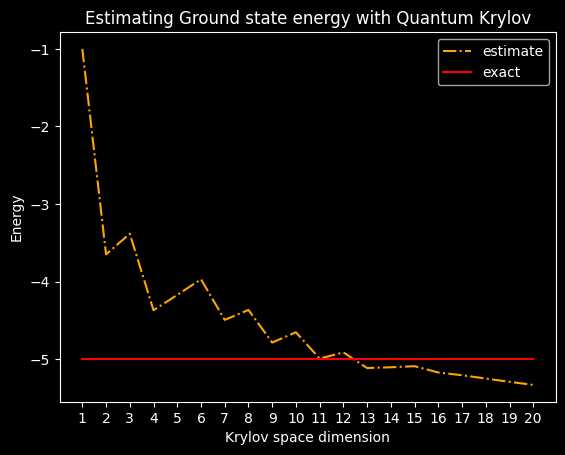

In [113]:
# plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list_0, color = 'blue', linestyle='-.' , label = 'estimate - res 0 ')
# plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list_1, color = 'yellow', linestyle='-.' , label = 'estimate - res 1 ')
# plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list_2, color = 'green', linestyle='-.' , label = 'estimate - res 2')
plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list, color = 'orange', linestyle='-.' , label = 'estimate')
plt.plot(range(1, krylov_dim+1), [gs_en]*krylov_dim, color = 'red', linestyle='-' , label = 'exact')
plt.xticks(range(1, krylov_dim+1), range(1, krylov_dim+1))
plt.legend()
plt.xlabel('Krylov space dimension')
plt.ylabel('Energy')
plt.title('Estimating Ground state energy with Quantum Krylov')
plt.show()

### Check Paulis

#### Theory calculation (phase issue with real expvals)

In [105]:
# THIS FUNCTION CALCULATES THE PAULI MATRICES FOR EACH DIMENSION IN d_list, USING NOBU'S k-PARTICLE CODE
# Note that passing in vectors_kp is optional but if you already have it from the Krylov matrix calculation, it can save time.
from utils_k_particle import compute_pauli_matrices
from utils_k_particle import get_indexes_for_m_particles, k_particle_excitation, simulate_unitary_kparticle_from_interaction_list

fixed_control = 0
excitations = [int(n_qubits/2)+1]
H = H_op     

k = len(excitations)
indices = get_indexes_for_m_particles(n_qubits, k)

initial_state_kp = k_particle_excitation(n_qubits, excitations, indices)
vectors_kp = [simulate_unitary_kparticle_from_interaction_list(interaction_list, initial_state_kp, n_qubits, k, num_trotter_steps, param = (i*dt)/num_trotter_steps, as_sparse = True) for i in range(krylov_dim)]

all_exp_vals, vectors_kp = compute_pauli_matrices(n_qubits, fixed_control, excitations, H, interaction_list, num_trotter_steps, dt, list(range(krylov_dim)), vectors_kp)



H_first_row_exact = np.zeros(krylov_dim, dtype=complex)
prefactors_exact = [1+0j] + prefactors
for i, expvals_dict in enumerate(all_exp_vals):


    res_dict_sim = {}
    for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
        # Get expectation values from experiment
        obs = observables_H_cliff[obs_idx]
        new_obs = obs[:-1]
        expval_real = expvals_dict[new_obs + 'X']
        expval_imag = expvals_dict[new_obs + 'Y']


        expval = expval_real + 1j*expval_imag

        H_first_row_exact[i] += prefactors_exact[i]*coeff*expval



H_first_row_exact_list = H_first_row_exact.tolist()           
            
H_eff_circ_exact = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff_circ_exact[j,i] = H_first_row_exact[i-j]
    else:
        H_eff_circ_exact[j,i] = np.conj(H_first_row_exact[j-i])

In [106]:
Matrix(H_eff_circ_exact)

Matrix([
[                                    -1.0,      1.574896636172 + 1.68065305025305*I,   -1.88010222236495 - 1.36045156899213*I,  0.501484835797266 + 0.338070486957958*I,  0.98032426964642 - 0.530138472481496*I,         -0.690113993640722 + 1.109375*I, -0.306832618286145 - 0.612680863883094*I, 0.262129581691104 - 0.0719796695665475*I,  0.109255335564696 - 0.313435134444483*I,  0.484493831686177 + 0.701351736957959*I],
[     1.574896636172 - 1.68065305025305*I,                                     -1.0,      1.574896636172 + 1.68065305025305*I,   -1.88010222236495 - 1.36045156899213*I, 0.501484835797266 + 0.338070486957958*I,  0.98032426964642 - 0.530138472481496*I,          -0.690113993640722 + 1.109375*I, -0.306832618286145 - 0.612680863883094*I, 0.262129581691104 - 0.0719796695665475*I,  0.109255335564696 - 0.313435134444483*I],
[  -1.88010222236495 + 1.36045156899213*I,      1.574896636172 - 1.68065305025305*I,                                     -1.0,      1.574896636172 + 1.

#### Numerical calculation (few qubits only!)

In [107]:
from qiskit.quantum_info import Statevector, Pauli

H_first_row_sim = np.zeros(krylov_dim, dtype=complex)
H_first_row_sim[0] = H_expval

S_first_row_sim = np.zeros(krylov_dim, dtype=complex)
S_first_row_sim[0] = 1+0j

all_exp_vals_sim = []
for i, param in enumerate(parameters):

    H_real_circ_cliff = H_real_circ.assign_parameters({t:param})
    H_imag_circ_cliff = H_imag_circ.assign_parameters({t:param})
    S_real_circ_cliff = S_real_circ.assign_parameters({t:param})
    S_imag_circ_cliff = S_imag_circ.assign_parameters({t:param})

    observables_S_cliff = 'I'*(n_qubits) + 'Z'

    observables_H_cliff = []
    for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
        # print(pauli)
        observable = pauli[::-1].to_label() + 'Z'
        observables_H_cliff.append(observable)



    # Get expectation values from experiment
    S_expval_real = Statevector(S_real_circ_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Z'))
    S_expval_imag = Statevector(S_imag_circ_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Z'))

    # Get expectation values
    S_expval = S_expval_real + 1j*S_expval_imag

    S_first_row_sim[i+1] += prefactors[i]*S_expval


    res_dict_sim = {}
    for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
        # Get expectation values from experiment
        expval_real = Statevector(H_real_circ_cliff).expectation_value(Pauli(observables_H_cliff[obs_idx]))
        expval_imag = Statevector(H_imag_circ_cliff).expectation_value(Pauli(observables_H_cliff[obs_idx]))
        obs = observables_H_cliff[obs_idx]
        new_obs = obs[:-1]
        res_dict_sim[new_obs + 'X'] = expval_real
        res_dict_sim[new_obs + 'Y'] = expval_imag


        expval = expval_real + 1j*expval_imag


        H_first_row_sim[i+1] += prefactors[i]*coeff*expval

    all_exp_vals_sim.append(res_dict_sim)


H_first_row_sim_list = H_first_row_sim.tolist()           
            
H_eff_circ_sim = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff_circ_sim[j,i] = H_first_row_sim[i-j]
    else:
        H_eff_circ_sim[j,i] = np.conj(H_first_row_sim[j-i])

            
            
S_circ_sim = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        S_circ_sim[j,i] = S_first_row_sim[i-j]
    else:
        S_circ_sim[j,i] = np.conj(S_first_row_sim[j-i])


In [108]:
gnd_en_circ_sim_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ_sim[:d, :d], S_circ_sim[:d, :d], threshold=4e-2)
    gnd_en_circ_sim_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

The estimated ground state energy is:  -1.0
The estimated ground state energy is:  -3.6605762752747246
The estimated ground state energy is:  -4.460359410171026
The estimated ground state energy is:  -4.31317056826243
The estimated ground state energy is:  -4.7294630016623165
The estimated ground state energy is:  -4.57418046634093
The estimated ground state energy is:  -5.093617843722571
The estimated ground state energy is:  -5.118070467436698
The estimated ground state energy is:  -5.665052613368128
The estimated ground state energy is:  -5.729189955986785


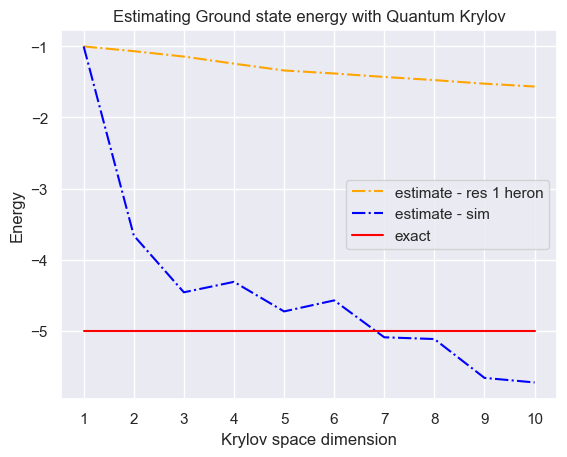

In [152]:
plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list, color = 'orange', linestyle='-.' , label = 'estimate - res 1 heron')
plt.plot(range(1, krylov_dim+1), gnd_en_circ_sim_est_list, color = 'blue', linestyle='-.' , label = 'estimate - sim')
plt.plot(range(1, krylov_dim+1), [gs_en]*krylov_dim, color = 'red', linestyle='-' , label = 'exact')
plt.xticks(range(1, krylov_dim+1), range(1, krylov_dim+1))
plt.legend()
plt.xlabel('Krylov space dimension')
plt.ylabel('Energy')
plt.title('Estimating Ground state energy with Quantum Krylov')
plt.show()

#### Experimental values

In [140]:
all_exp_vals_exp = []
for idx in range(krylov_dim-1):
    res_dict = {}
    for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
        # Get expectation values from experiment
        expval_real = H_real_results.data.evs[obs_idx][idx]
        expval_imag = H_imag_results.data.evs[obs_idx][idx]
        obs = observables_H_cliff[obs_idx]
        new_obs = obs[:-1]
        res_dict[new_obs + 'X'] = expval_real
        res_dict[new_obs + 'Y'] = expval_imag
    all_exp_vals_exp.append(res_dict)



#### Compare

In [149]:
idx  = 0
print('PAULI', '   EXP', '   SIM')
for pauli, val in all_exp_vals_exp[idx].items():
    
    # if pauli[-1] == 'X' and abs(np.round(phase_factor.real, 2)) > 0:
    #     all_exp_vals[idx+1][pauli] = phase_factor.real*all_exp_vals[idx+1][pauli]
    # if pauli[-1] == 'Y' and abs(np.round(phase_factor.imag, 2)) > 0:
    #     all_exp_vals[idx+1][pauli] = phase_factor.imag*all_exp_vals[idx+1][pauli]


    print(pauli, np.round(val, 3), np.round(all_exp_vals_sim[idx][pauli],3) )#, np.round(all_exp_vals[idx+1][pauli], 3))

PAULI    EXP    SIM
IIIIZZX -0.004 0.199
IIIIZZY -0.049 -0.612
IIIZZIX -0.005 0.199
IIIZZIY 0.0 -0.612
IIZZIIX -0.002 -0.199
IIZZIIY -0.019 0.612
IZZIIIX 0.021 -0.199
IZZIIIY 0.008 0.612
ZZIIIIX 0.001 0.199
ZZIIIIY 0.031 -0.612
IIIIXXX -0.0 -0.0
IIIIXXY 0.01 0.0
IIIXXIX -0.0 0.0
IIIXXIY 0.0 0.0
IIXXIIX -0.0 -0.484
IIXXIIY 0.01 -0.157
IXXIIIX -0.001 -0.491
IXXIIIY -0.0 -0.154
XXIIIIX 0.003 0.0
XXIIIIY 0.002 0.0
IIIIYYX -0.003 0.0
IIIIYYY 0.002 -0.0
IIIYYIX 0.002 -0.0
IIIYYIY 0.003 -0.0
IIYYIIX 0.004 -0.484
IIYYIIY 0.01 -0.157
IYYIIIX 0.038 -0.491
IYYIIIY -0.011 -0.154
YYIIIIX -0.0 -0.0
YYIIIIY 0.0 0.0


In [112]:
idx  = 0
for pauli, val in all_exp_vals_exp[idx].items():
    if abs(val) > 0.1:
        damp_sim = abs(val/all_exp_vals_sim[idx][pauli])
        damp_ex = abs(val/all_exp_vals[idx+1][pauli])
        print(pauli, np.round(damp_sim, 3), np.round(damp_ex,3))

IIIZZIX 1.851 2.283
IIIZZIY 0.284 0.278
IIZZIIX 1.931 2.382
IIZZIIY 0.202 0.198
IZZIIIX 0.769 0.948
IIIIXXX 2.845026813638794e+17 inf
IIIXXIX 3.533339867983525e+17 inf
IIIXXIY 1.3891352118779706e+17 inf
IIXXIIX 0.635 inf
IIXXIIY 1.199 inf
IXXIIIY 2.069 2.069
XXIIIIY 5.765001297232687e+16 2.179
IIIIYYX 1.8997944401832097e+18 inf
IIIIYYY 5.7525604930955437e+17 inf
IIIYYIX 3.484167010586783e+16 inf
IYYIIIX 0.337 0.337
YYIIIIX 3.19503439136049e+16 0.516
YYIIIIY 6.159127066059349e+16 0.997


### Save data

In [ ]:
import os
import pickle
import time

time_string = time.strftime("%m%d%Y_%H%M%S")
data_dir_path = f'data/{backend_id}_{n_qubits}q_{time_string}/'
# Save experiment parameters
var_dict = {k: globals()[k] for k in [ 'n_qubits',
                                        'J',
                                        'H_tot',
                                        'dt',
                                        'krylov_dim',
                                        'num_trotter_steps',
                                        'dt_circ',
                                        'parameters',
                                        'backend_id',
                                        'shots',
                                        'observables_S',
                                        'observables_H',
                                        'pub_S_real',
                                        'pub_S_imag',
                                        'pub_H_real',
                                        'pub_H_imag',
                                        'job_S_real_id',
                                        'job_S_imag_id',
                                        'job_H_real_id',
                                        'job_H_imag_id',
                                        'S_expval',
                                        'H_expval',
                                        'prefactors',
                                        'S_first_row_list',
                                        'H_first_row_list',
                                        'n_exc',
                                        'gs_en',]}



# Save to Box folder (avoid Github large file storage issues)
os.makedirs(os.path.dirname(data_dir_path), exist_ok=True)
fname = data_dir_path + "experiment_parameters.pickle"
with open(fname, "wb") as f:
    pickle.dump(var_dict, f)


np.save(data_dir_path + 'S_real_results_evs', S_real_results.data.evs)
np.save(data_dir_path + 'S_imag_results_evs', S_imag_results.data.evs)
np.save(data_dir_path + 'H_real_results_evs', H_real_results.data.evs)
np.save(data_dir_path + 'H_imag_results_evs', H_imag_results.data.evs)

np.save(data_dir_path + 'S_real_results_metadata', S_real_results.metadata)
np.save(data_dir_path + 'S_imag_results_metadata', S_imag_results.metadata)
np.save(data_dir_path + 'H_real_results_metadata', H_real_results.metadata)
np.save(data_dir_path + 'H_imag_results_metadata', H_imag_results.metadata)